In [111]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

In [112]:
filterwarnings('ignore')
pd.set_option('display.max_columns', None) # bütün satırları göster
pd.set_option('display.width', 200) # genişlik 200 olsun 
pd.set_option('display.float_format', lambda x: '%.2f' % x) # float formatındakileri hep virgülden sonra 2 basamak şeklinde göster

In [113]:
df = pd.read_csv("/home/baki/Downloads/nlp-220913-124842/nlp/datasets/amazon_reviews.csv", sep=",")

In [114]:
df.head()

# reviewer ID : kullanıcılar
# asin : Ürün
# reviewer name: kullanıcıların ismi
# helpful : faydalı olup olmadıkları
# reviewtext : yorumlar
# overall : verdiği puan, yıldız
# summary : Yorumların özeti
# unixreview & review time : yorumun zaman bilgisi
# day diff : yorumun kaç gün geçtiği
# helpful yes : yardımcı oldu mu 
# total vote : toplam oy 

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.00,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.00,best deal around,1373673600,2013-07-13,513,0,0


In [115]:
df["reviewText"] = df["reviewText"].str.lower()

In [116]:
#noktalama işaretlerini de siliyoruz ancak amacımıza göre bunların kalmasını isteyebiliriz ben genelleme yapıyorum.
df["reviewText"] = df["reviewText"].str.replace('[^\w\s]',"",regex=True)
# ^ : Bu ifade, köşeli parantezler içinde verilen karakterlerin dışındaki tüm karakterleri seçer.
# \w : Bu, kelime dışı karakterleri (harf, rakam ve alt çizgi olmayan her şey) ifade eder. Örneğin, boşluk, nokta, virgül gibi karakterler burada yer alır.
# \s : Bu, boşluk olmayan karakterleri ifade eder. Yani, boşluk karakterini hariç tutar.

In [117]:
df.head

<bound method NDFrame.head of           reviewerID        asin  reviewerName helpful                                         reviewText  overall                                 summary  unixReviewTime  reviewTime  day_diff  \
0     A3SBTW3WS4IQSN  B007WTAJTO           NaN  [0, 0]                                          no issues     4.00                              Four Stars      1406073600  2014-07-23       138   
1     A18K1ODH1I2MVB  B007WTAJTO          0mie  [0, 0]  purchased this for my device it worked as adve...     5.00                           MOAR SPACE!!!      1382659200  2013-10-25       409   
2     A2FII3I2MBMUIA  B007WTAJTO           1K3  [0, 0]  it works as expected i should have sprung for ...     4.00               nothing to really say....      1356220800  2012-12-23       715   
3      A3H99DFEG68SR  B007WTAJTO           1m2  [0, 0]  this think has worked out greathad a diff bran...     5.00  Great buy at this price!!!  *** UPDATE      1384992000  2013-11-21    

In [118]:
# sayılardan da kurtulalım.

df["reviewText"] = df["reviewText"].str.replace('\d','', regex=True)

In [119]:
df.head

<bound method NDFrame.head of           reviewerID        asin  reviewerName helpful                                         reviewText  overall                                 summary  unixReviewTime  reviewTime  day_diff  \
0     A3SBTW3WS4IQSN  B007WTAJTO           NaN  [0, 0]                                          no issues     4.00                              Four Stars      1406073600  2014-07-23       138   
1     A18K1ODH1I2MVB  B007WTAJTO          0mie  [0, 0]  purchased this for my device it worked as adve...     5.00                           MOAR SPACE!!!      1382659200  2013-10-25       409   
2     A2FII3I2MBMUIA  B007WTAJTO           1K3  [0, 0]  it works as expected i should have sprung for ...     4.00               nothing to really say....      1356220800  2012-12-23       715   
3      A3H99DFEG68SR  B007WTAJTO           1m2  [0, 0]  this think has worked out greathad a diff bran...     5.00  Great buy at this price!!!  *** UPDATE      1384992000  2013-11-21    

In [120]:
# bu, şu, gibi ifadelerini kaldırmalıyız bir anlam ifade etmediği için 
import nltk

In [121]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/baki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [122]:
sw = stopwords.words("english") # turkish yaparsak türkçe de bulunan şu,bu gibi ifadeleri bulabiliriz

In [123]:
df["reviewText"] = df["reviewText"].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

In [124]:
# bir kelimeden 1 den fazla geçiyorsa onu da çıkarabiliriz 

temp_df = pd.Series(" ".join(df["reviewText"]).split()).value_counts()
temp_df

card          4603
gb            1725
phone         1685
works         1559
great         1445
              ... 
sharper          1
cheapos          1
gate             1
measuring        1
stealwould       1
Name: count, Length: 9701, dtype: int64

In [125]:
drops = temp_df[temp_df < 2]

In [126]:
df["reviewText"] = df["reviewText"].apply(lambda x: " ".join(x for x in str(x).split() if x not in drops))

In [127]:
df.head

<bound method NDFrame.head of           reviewerID        asin  reviewerName helpful                                         reviewText  overall                                 summary  unixReviewTime  reviewTime  day_diff  \
0     A3SBTW3WS4IQSN  B007WTAJTO           NaN  [0, 0]                                             issues     4.00                              Four Stars      1406073600  2014-07-23       138   
1     A18K1ODH1I2MVB  B007WTAJTO          0mie  [0, 0]  purchased device worked advertised never much ...     5.00                           MOAR SPACE!!!      1382659200  2013-10-25       409   
2     A2FII3I2MBMUIA  B007WTAJTO           1K3  [0, 0]  works expected higher capacity think made bit ...     4.00               nothing to really say....      1356220800  2012-12-23       715   
3      A3H99DFEG68SR  B007WTAJTO           1m2  [0, 0]  think worked gb card went south one held prett...     5.00  Great buy at this price!!!  *** UPDATE      1384992000  2013-11-21    

In [128]:
# cümleleri kendi içerisinde tokenlarına ayılarım

nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/baki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [129]:
import spacy

nlp = spacy.load("en_core_web_sm")

#punkt çalışmadığı için hemen hemen aynı işlevi gören spacy kütüphanesini kurup bununla tokenlarına ayırıyorum bakıyorum.


In [130]:
df["reviewText"].apply(lambda x: [token.text for token in nlp(x)])

0                                                [issues]
1       [purchased, device, worked, advertised, never,...
2       [works, expected, higher, capacity, think, mad...
3       [think, worked, gb, card, went, south, one, he...
4       [bought, retail, packaging, arrived, legit, en...
                              ...                        
4910    [bought, sandisk, gb, class, use, htc, inspire...
4911    [used, capabilities, samsung, galaxy, note, gr...
4912    [great, card, fast, reliable, comes, optional,...
4913    [good, amount, space, stuff, want, fits, gopro...
4914    [i, ve, heard, bad, things, gb, micro, sd, car...
Name: reviewText, Length: 4915, dtype: object

In [131]:
nltk.download("wordnet") # kelimeleri köklerine ayırma işlemi için gereken modül

[nltk_data] Downloading package wordnet to /home/baki/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [132]:
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

## Metin görselleştirme 

In [133]:
# görselleştirme için numeric bir şey olmadığından metinlerin frekanslarını sayalım.

tf = df["reviewText"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index() 

In [134]:
tf

,index,0
0,issue,609.00
1,purchased,344.00
2,device,584.00
3,worked,460.00
4,advertised,111.00
...,...,...
3686,pureview,3.00
3687,laptoptablet,2.00
3688,employee,2.00
3689,sandisksequential,2.00


In [135]:
tf.columns = ["words", "tf"]

In [136]:
tf.sort_values("tf")

,words,tf
1098,,1.00
1845,cancer,2.00
2642,crossed,2.00
2636,debating,2.00
2634,skydrive,2.00
...,...,...
98,great,1445.00
39,gb,1756.00
7,phone,1909.00
14,work,2044.00


In [137]:
tf500 = tf[tf["tf"] > 500]

<Axes: xlabel='words'>

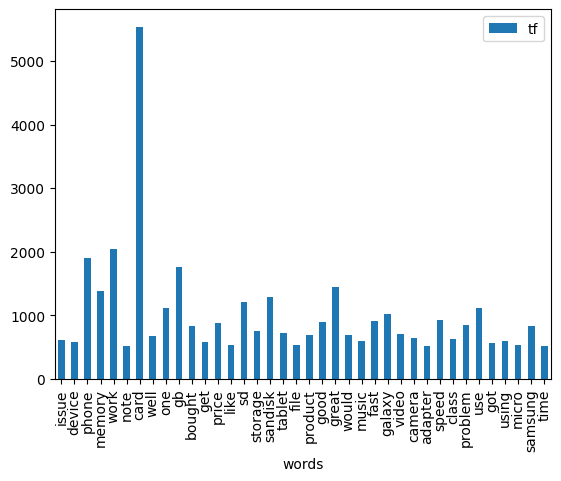

In [138]:
tf500.plot.bar("words")

In [139]:
## WordCloud

text = " ".join(i for i in df["reviewText"])

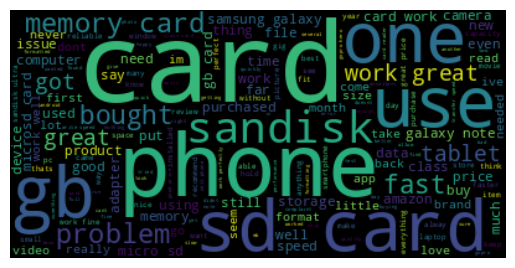

In [140]:
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


## Sentiment modellemesi (duygu durum analizi)

In [141]:
df["reviewText"].head()

0                                                issue
1    purchased device worked advertised never much ...
2    work expected higher capacity think made bit e...
3    think worked gb card went south one held prett...
4    bought retail packaging arrived legit envelope...
Name: reviewText, dtype: object

In [142]:
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/baki/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [143]:
sia = SentimentIntensityAnalyzer()

In [144]:
sia.polarity_scores("the film was awesome") # negatif, nötr, positif ve birleşim parametreleri var. -1 ile 1 arası compound

{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'compound': 0.6249}

In [145]:
df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x))

0    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
2    {'neg': 0.0, 'neu': 0.803, 'pos': 0.197, 'comp...
3    {'neg': 0.0, 'neu': 0.798, 'pos': 0.202, 'comp...
4    {'neg': 0.0, 'neu': 0.747, 'pos': 0.253, 'comp...
5    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
6    {'neg': 0.108, 'neu': 0.598, 'pos': 0.295, 'co...
7    {'neg': 0.077, 'neu': 0.65, 'pos': 0.272, 'com...
8    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
9    {'neg': 0.0, 'neu': 0.457, 'pos': 0.543, 'comp...
Name: reviewText, dtype: object

In [146]:
df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"]) # ilk 10 yorumun pozitiflik negatiflik yorumu

0   0.00
1   0.00
2   0.40
3   0.65
4   0.86
5   0.00
6   0.87
7   0.82
8   0.00
9   0.92
Name: reviewText, dtype: float64

In [147]:
df["polarity_score"] = df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

In [152]:
df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,polarity_score,sentiment_label
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",issue,4.00,Four Stars,1406073600,2014-07-23,138,0,0,0.00,neg
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]",purchased device worked advertised never much ...,5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,0.00,neg
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",work expected higher capacity think made bit e...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0,0.40,pos
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",think worked gb card went south one held prett...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,0.65,pos
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]",bought retail packaging arrived legit envelope...,5.00,best deal around,1373673600,2013-07-13,513,0,0,0.86,pos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4910,A2LBMKXRM5H2W9,B007WTAJTO,"ZM ""J""","[0, 0]",bought sandisk gb class use htc inspire month ...,1.00,Do not waste your money.,1374537600,2013-07-23,503,0,0,NaN,NaN
4911,ALGDLRUI1ZPCS,B007WTAJTO,Zo,"[0, 0]",used capability samsung galaxy note greatly ex...,5.00,Great item!,1377129600,2013-08-22,473,0,0,NaN,NaN
4912,A2MR1NI0ENW2AD,B007WTAJTO,Z S Liske,"[0, 0]",great card fast reliable come optional adapter...,5.00,Fast and reliable memory card,1396224000,2014-03-31,252,0,0,NaN,NaN
4913,A37E6P3DSO9QJD,B007WTAJTO,Z Taylor,"[0, 0]",good amount space stuff want fit gopro say,5.00,Great little card,1379289600,2013-09-16,448,0,0,NaN,NaN


## feature engineering

In [149]:
# Burada amacımız şöyle olabilir denetimsiz öğrenme yaparak bir duygu durum pozitiflik algısı alabiliyoruz yorumlardan ancak
# bunu label haline alırsak bir sınıflandırma projesine dönüşebilir örneğin bir şirketin premium gold silver üyelerinin yorumlarını 
# analiz edersek, belli bir noktadan sonra bunu gelen yorumlardan rahat sınıflandırma haline getiren modele dönüştürebiliriz ?

In [154]:
df["sentiment_label"] = df["reviewText"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

In [156]:
df["sentiment_label"].value_counts()

sentiment_label
pos    3944
neg     971
Name: count, dtype: int64

In [161]:
df.groupby("sentiment_label")["overall"].mean() # sentiment_label a göre puanlama ortalaması (bağımlı değişken)

sentiment_label
neg   4.09
pos   4.71
Name: overall, dtype: float64

In [162]:
# fakat bu gruplandırmalar string isimlendirmeye sahipler bi label encoder dan geçirelim

df["sentiment_label"] = LabelEncoder().fit_transform(df["sentiment_label"])

In [167]:
y = df["sentiment_label"]

X = df["reviewText"] # bu bir metin nasıl bağımsız değişken olacak ? değil mi.

## COUNT VECTORS

In [171]:
# kelimelerden işlem yapmamız için gerekli olan kelime vektörleri oluşturmaktır

# Count Vectors: frekans temsiller
# TF-IDF Vectors: normalize edilmiş frekans temsiller
# Word Embeddings (Word2Vec, GloVe, BERT vs)

# metinleri liner cebir dünyasında işlenebilen hale getirmek için gerekli.

In [184]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /home/baki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [185]:
import nltk
print(nltk.data.path)


['/home/baki/nltk_data', '/home/baki/Desktop/AI/nltk_data', '/home/baki/Desktop/AI/share/nltk_data', '/home/baki/Desktop/AI/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data', '/home/baki/nltk_data/tokenizers/punkt/']


In [187]:
# count vector kullanıcaz ama neyi sayıcaz biz 

# words
# kelimelerin nümerik temsilleri

# characters
# karakterlerin numerik temsilleri

# ngram 

In [188]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = ['This is the first document.',
          'This document is the second document.',
          'And this is the third one.',
          'Is this the first document?']

In [204]:
# WORD FREKANS (COUNT)
vectorizerr = CountVectorizer()
X_c = vectorizerr.fit_transform(corpus)
vectorizerr.get_feature_names_out()

array(['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third',
       'this'], dtype=object)

In [205]:
X_c.toarray()

# bu çıktı şu anlama geliyor ;
# and kelimesi ilk cümlede var mı yok o yüzden 0. document ilk cümlede var mı evet var 1 tane. böyle böyle tüm kelimeler tek tek
# bütün satırlarda bakılıyor ve 0 veya 1 konuyor.
# 2 olan ne o zaman derseniz, 2 defa kullanılmış demek. 

array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 2, 0, 1, 0, 1, 1, 0, 1],
       [1, 0, 0, 1, 1, 0, 1, 1, 1],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]])

In [206]:
# n-gram frekans
vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2)) # bu da 2 ye 2 olacak şekilde ngramları çıkarıyor ve aynı şekilde bakıyoruz 
X_n = vectorizer2.fit_transform(corpus)
vectorizer2.get_feature_names_out()

array(['and this', 'document is', 'first document', 'is the', 'is this',
       'second document', 'the first', 'the second', 'the third',
       'third one', 'this document', 'this is', 'this the'], dtype=object)

In [207]:
X_n.toarray()


array([[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
       [0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1]])

In [208]:
vectorizer = CountVectorizer()
X_count = vectorizer.fit_transform(X)


In [211]:
vectorizer.get_feature_names_out()[10:15]
X_count.toarray()[10:15]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [214]:
# Tf-IDF Yöntemi 



# Tf = frekans / dökümandaki toplam terim sayisi 

# IDF = 1 + loge((toplam döküman sayısı+1) / (içinde t terimi olan döküman sayısı+1))

# tf-IDF = tf * IDF

# L2 normalizasyonu = satırların karelerinin toplamının karekökünü bul, ilgili satırdaki tüm hücreleri bulduğun değere böl 


In [215]:

from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_word_vectorizer = TfidfVectorizer()
X_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X)

In [216]:
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2, 3))
X_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(X)

In [218]:
# logistic regression

log_model = LogisticRegression().fit(X_tf_idf_word, y)

cross_val_score(log_model,
                X_tf_idf_word,
                y,
                scoring="accuracy",
                cv=5).mean()

0.830111902339776

In [219]:
new_review = pd.Series("this product is great")

In [220]:
new_review = TfidfVectorizer().fit(X).transform(new_review)

In [221]:
log_model.predict(new_review)

array([1])

In [222]:
###############################
# Random Forests
###############################

# Count Vectors
rf_model = RandomForestClassifier().fit(X_count, y)
cross_val_score(rf_model, X_count, y, cv=5, n_jobs=-1).mean()

# TF-IDF Word-Level
rf_model = RandomForestClassifier().fit(X_tf_idf_word, y)
cross_val_score(rf_model, X_tf_idf_word, y, cv=5, n_jobs=-1).mean()

# TF-IDF N-GRAM
rf_model = RandomForestClassifier().fit(X_tf_idf_ngram, y)
cross_val_score(rf_model, X_tf_idf_ngram, y, cv=5, n_jobs=-1).mean()


0.7857578840284842